In [10]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import csv

In [11]:
clean_filenames_list = []

%matplotlib inline

for filename in os.listdir('/Users/owainpill/Documents/GitHub/SiotDataAnalysis/imageprocessing/processedimagesexp4'):
    if filename.endswith(".jpg"):
        # print(filename)
        # print(filename.split('size'))
        name_wo_size = filename.split('size')
        name_wo_jpg = name_wo_size[1].split('.jpg')
        name_cleaned = [name_wo_size[0], name_wo_jpg[0][0:10], datetime.datetime.fromtimestamp(int(name_wo_jpg[0][0:10])).strftime('%Y-%m-%d %H:%M:%S')]## taking only first ten characters as this is epoch time in seconds
        # print(name_cleaned)
        clean_filenames_list.append(name_cleaned)


df = pd.DataFrame(clean_filenames_list, columns=['ycoord', 'epochtime', 'datetime'])
df['ycoord'] = df['ycoord'].astype(int)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['datetime'])
df = df.reset_index(drop=True)
# print(df)

df


,ycoord,epochtime,datetime
0,396,1701898576,2023-12-06 21:36:16
1,2171,1701898589,2023-12-06 21:36:29
2,1708,1701898595,2023-12-06 21:36:35
3,1393,1701898601,2023-12-06 21:36:41
4,1199,1701898607,2023-12-06 21:36:47
...,...,...,...
181,2186,1701903288,2023-12-06 22:54:48
182,2169,1701903294,2023-12-06 22:54:54
183,2167,1701903300,2023-12-06 22:55:00
184,2178,1701903306,2023-12-06 22:55:06


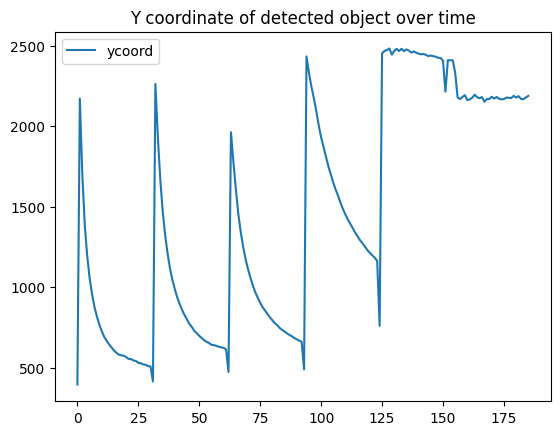

In [12]:
graph = df.plot(y='ycoord', kind='line', title='Y coordinate of detected object over time')#plot position without taking time into account

In [13]:
# df['velocity'] = df['ycoord'].diff() / df['datetime'].diff().dt.total_seconds()
# print(type(df['datetime'][4]))
# %matplotlib inline
# plt.plot(df['datetime'], df['velocity'])

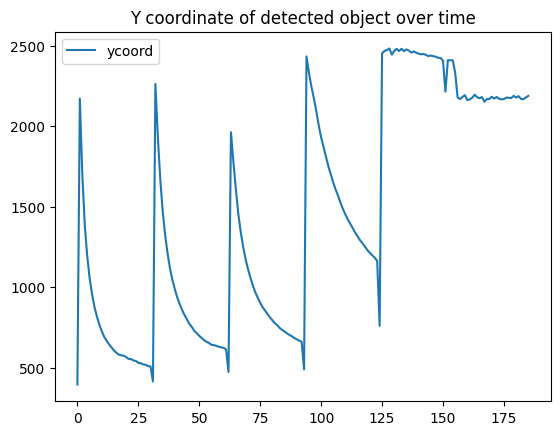

In [14]:
## Split data into different days
# mask = (df['datetime'] > '2023-12-4') & (df['datetime'] <= '2023-12-6')
mask = (df['datetime'] > '2023-12-06 18:00:00') & (df['datetime'] <= '2023-12-06 23:59:59')
df_test1 = df.loc[mask]
graph = df_test1.plot(y='ycoord', kind='line', title='Y coordinate of detected object over time')#plot position without taking time into account

/var/folders/6n/df4bbytx0tqfkq05t0fhwb080000gn/T/ipykernel_65146/3127243441.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['velocity'][1] = np.nan ## first value gets past the other logic check as it does not have a time beofre
/var/folders/6n/df4bbytx0tqfkq05t0fhwb080000gn/T/ipykernel_65146/3127243441.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['velocity'][2] = np.nan ## first value gets past the other logic check as it does not have a time beofre
/var/folders/6n/df4bbytx0tqfkq05t0fhwb080000gn/T/ipykernel_65146/3127243441.py:19: SettingWithCopyWarning: 
A value is trying to be set on a

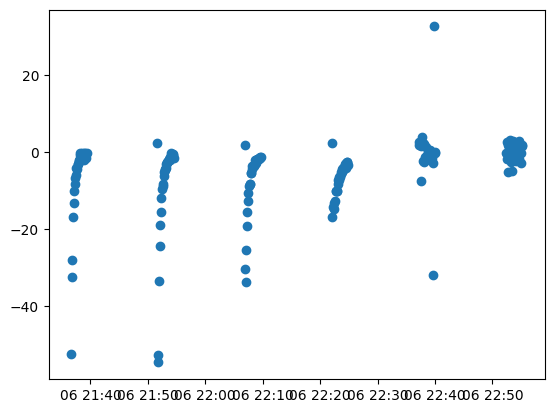

In [15]:
### remove data from the image that is taken just before the printer rotates again - the silicone has had a lot of time to move - hard to get an idea of velocity
df_test1['timenext'] = df_test1['datetime'].shift(-1)

for index, row in df_test1.iterrows():
    # print(index, row['timenext']-row['datetime'])
    if row['timenext']-row['datetime'] > datetime.timedelta(seconds=300):
        # print('found one')
        df_test1.drop(index+1, inplace=True)
    # print(index, row)

df_test1.reset_index(drop=True, inplace=True)


df_test1['velocity'] = df_test1['ycoord'].diff() / df_test1['datetime'].diff().dt.total_seconds()

## remove outliers, manual for now - need to automate
df_test1['velocity'][1] = np.nan ## first value gets past the other logic check as it does not have a time beofre
df_test1['velocity'][2] = np.nan ## first value gets past the other logic check as it does not have a time beofre
df_test1['velocity'][93] = np.nan ## first value gets past the other logic check as it does not have a time beofre
df_test1['velocity'][123] = np.nan ## first value gets past the other logic check as it does not have a time beofre



plt.scatter(df_test1['datetime'], df_test1['velocity'])

In [16]:
### average out the velocity for each printer rotate

velocities_avg = []
velocities_avg_split =[]


## go through all the timestamps and see where there are big gaps in time - this is where the printer rotates
## then average out the velocities in between these gaps
for index, row in df_test1.iterrows():
    # print(index, row['timenext']-row['datetime'])
    if row['timenext']-row['datetime'] < datetime.timedelta(seconds=300):
        # print('found one')
        velocities_avg.append(row['velocity'])
    else:
        #print(velocities_avg)
        velocities_avg = [x for x in velocities_avg if str(x) != 'nan']
        #print(velocities_avg)
        # velocities_avg = velocities_avg.sort(reverse=True)
        #print('HAH')

        ###velocities_avg = sorted(velocities_avg)[0:10]## sort by fastest and return top 10 for averaging as the silicone slows down as it reaches the bottom of the tube
        
        velocities_avg_split.append(np.nanmean(velocities_avg))##ignore nan values
        velocities_avg_split.append(row['datetime'])#give datetime to match up with temps


        #print(velocities_avg_split)
        ## sort and take top 10 values - these are the fastest
        ##taking fastest as the speed slows down as it reaches the bottom of the tube
        velocities_avg = []

print(velocities_avg_split)

[-7.61604938271605, Timestamp('2023-12-06 21:39:19'), -9.710330866955188, Timestamp('2023-12-06 21:54:30'), -7.647530288909599, Timestamp('2023-12-06 22:09:40'), -7.044240669240669, Timestamp('2023-12-06 22:24:50'), -0.2777176457627586, Timestamp('2023-12-06 22:40:01'), 0.015687095723393326, Timestamp('2023-12-06 22:55:12')]


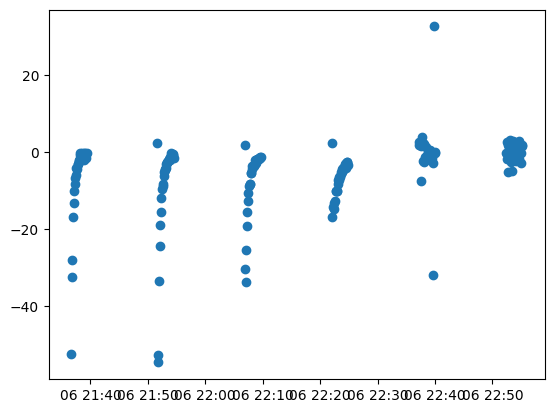

In [17]:
##Show the location of the average velocities on the graph
%matplotlib inline
plt.scatter(df_test1['datetime'], df_test1['velocity'])

# y = np.array(velocities_avg_split)
# ticks = ['1', '2', '3', '4', '5']

# plt.yticks(y, ticks)

plt.show()

In [18]:
with open('exp4vel.csv', 'w') as f:
     
    # using csv.writer method from CSV package
    write = csv.writer(f)
     
    write.writerow(velocities_avg_split)